In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from numpy import sin, cos, tan
from scipy import integrate
from quadcopter_animation import animation

In [12]:
import torch.nn as nn
from tqdm import tqdm
from Network_Training import TrajectoryDataset
from normalize import Normalize
import argparse
import yaml
import sys
sys.path.append("C:\\Users\\tavar\\Desktop\\Thesis\\Code\\spiking\\core\\torch")
sys.path.append("C:\\Users\\tavar\\Desktop\\Thesis\\Code\\spiking")
from core.torch.model import get_model, BaseModel
from core.torch.layer import LinearCubaLif


class ModelController(BaseModel):
    def __init__(self, e1, e2, e3, p1):
        super().__init__()

        self.e1 = LinearCubaLif(**e1)
        self.e2 = LinearCubaLif(**e2)
        self.e3 = LinearCubaLif(**e3)
        self.p1 = nn.LazyLinear(**p1)

    def forward(self, input):
        x = self.e1(input)
        x = x.flatten(start_dim=1)
        x = self.e2(x)
        x = x.flatten(start_dim=1)
        x = self.e3(x)
        x = x.flatten(start_dim=1)
        x = self.p1(x)
        return x

    def reset(self):
        self.e1.reset()
        self.e2.reset()
        self.e3.reset()

In [22]:
parser = argparse.ArgumentParser()
parser.add_argument("--config", type=str, default="C:/Users/tavar/Desktop/Thesis/Code/spiking/examples/torch/mnist/controller_e2e_train.yaml")
parser.add_argument("--debug", action="store_true")
args, unknown = parser.parse_known_args()

with open(args.config, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# trajectories containing 199 points
dataset_path = 'C:\\Users\\tavar\\Desktop\\Thesis\\Code\\quad_SL\\datasets\\hover_dataset.npz'

device = "cpu"
device = torch.device(device)
input_labels = ['dx', 'dy', 'dz', 'vx', 'vy', 'vz', 'phi', 'theta', 'psi', 'p', 'q', 'r','omega', 'u', 'Mx_ext', 'My_ext', 'Mz_ext']

dataset = dict()
print('loading dataset...')
with np.load(dataset_path) as full_dataset:
    # total number of trajectories
    num = len(full_dataset['dx'])
    steps = full_dataset['dx'].shape[1]
    print(num, 'trajectories')
    dataset = {key: full_dataset[key] for key in input_labels}

reduced_dict = {}
desired_rows = 50000  # Number of rows to keep (10% of 100000)

for key, value in dataset.items():
    # Assuming `value` is a NumPy array of shape (100000, 199)
    if isinstance(value, np.ndarray):
        # Slice the array to keep only the first `desired_rows` rows
        if value.ndim == 2:
            reduced_value = value[:desired_rows, :]
        else:
            reduced_value = value[:desired_rows]
        reduced_dict[key] = reduced_value

dataset_train = reduced_dict
num = dataset_train['dx'].shape[0]
steps = dataset_train['dx'].shape[1]
print(num, 'trajectories')

# Create a DataLoader
# testing_dataset_input = DataLoader(test_set, shuffle=False)

# get model and trace it
# x, y = next(iter(testing_dataset_input))
# print("Input size:", x[0, :].size())
x = np.array([[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]])
model = get_model(ModelController, config["model"], data=torch.tensor(x[0, :], dtype=torch.float32), device=device)
model.load_state_dict(torch.load('C:/Users/tavar/Desktop/Thesis/Code/spiking/examples/torch/mnist/models/model_controller_e2e_SL_50000_samples_Robin.pth'))
model.eval()

for p in model.parameters():
    p.requires_grad = False

loading dataset...
100000 trajectories
50000 trajectories


c:\Users\tavar\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [23]:
def transform(X):
    # TRANSFORM COORDINATES TO BODY FRAME
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r, utau1, utau2, utau3, utau4, Mx, My, Mz = X
    Rx = np.array([[1, 0, 0], [0, np.cos(phi), -np.sin(phi)], [0, np.sin(phi), np.cos(phi)]])
    Ry = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
    Rz = np.array([[np.cos(psi), -np.sin(psi), 0], [np.sin(psi), np.cos(psi), 0], [0, 0, 1]])
    R = Rz@Ry@Rx
    
    # new state variables
    xn, yn, zn = -R.T@[x,y,z]
    vxn, vyn, vzn = R.T@[vx,vy,vz]
    
    Xn = np.array([xn, yn, zn, vxn, vyn, vzn, phi, theta, psi, p, q, r, utau1, utau2, utau3, utau4, Mx, My, Mz])
    return Xn

def transform_back(X):
    # TRANSFORM COORDINATES TO WORLD FRAME
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r, utau1, utau2, utau3, utau4, Mx, My, Mz = X
    Rx = np.array([[1, 0, 0], [0, np.cos(phi), -np.sin(phi)], [0, np.sin(phi), np.cos(phi)]])
    Ry = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
    Rz = np.array([[np.cos(psi), -np.sin(psi), 0], [np.sin(psi), np.cos(psi), 0], [0, 0, 1]])
    R = Rz@Ry@Rx
    
    # new state variables
    xn, yn, zn = -R@[x,y,z]
    vxn, vyn, vzn = R@[vx,vy,vz]
    
    Xn = np.array([xn, yn, zn, vxn, vyn, vzn, phi, theta, psi, p, q, r, utau1, utau2, utau3, utau4, Mx, My, Mz])
    return Xn

In [24]:
# trajectory dataset
dataset_path = 'C:\\Users\\tavar\\Desktop\\Thesis\\Code\\quad_SL\\datasets\\hover_dataset.npz'
dataset = np.load(dataset_path)

g         = dataset['g']
mass      = dataset['mass']
Ixx       = dataset['Ixx']
Iyy       = dataset['Iyy']
Izz       = dataset['Izz']

k_x       = dataset['k_x']
k_y       = dataset['k_y']
k_z       = dataset['k_z']
k_omega   = dataset['k_omega']
k_h       = dataset['k_h']
k_p       = dataset['k_p']
k_pv      = dataset['k_pv']
k_q       = dataset['k_q']
k_qv      = dataset['k_qv']
k_r1      = dataset['k_r1']
k_r2      = dataset['k_r2']
k_rr      = dataset['k_rr']

omega_max = dataset['omega_max']
omega_min = dataset['omega_min']
tau       = dataset['tau']

print(omega_min, omega_max)
print(dataset['dx'].shape)
print(tau)

print(g, Ixx, Iyy, Izz, k_x, k_y, k_z, k_omega, k_h, k_p, k_pv, k_q, k_qv, k_r1, k_r2, k_rr, tau, sep=',')

5000.0 10000.0
(100000, 199)
0.06
9.81,0.000906,0.001242,0.002054,1.07933887e-05,9.65250793e-06,2.7862899e-05,4.36301076e-08,0.0625501332,1.4119331e-09,-0.00797101848,1.21601884e-09,0.0129263739,2.57035545e-06,4.10923364e-07,0.000812932607,0.06


In [44]:
Mx0, My0, Mz0 = 0, 0, 0

In [45]:
def dynamics(t, y, u):    
    # state
    dx, dy, dz, vx, vy, vz, phi, theta, psi, p, q, r, omega1, omega2, omega3, omega4, Mx, My, Mz = y
    
    # control input
    u1, u2, u3, u4 = u
    
    d_dx    = -q*dz + r*dy - vx
    d_dy    =  p*dz - r*dx - vy
    d_dz    = -p*dy + q*dx - vz
    
    omegas = omega1 + omega2 + omega3 + omega4
    omegas2 = omega1**2 + omega2**2 + omega3**2 + omega4**2
    
    d_vx    = -q*vz + r*vy - g*sin(theta) - k_x*omegas*vx
    d_vy    =  p*vz - r*vx + g*cos(theta)*sin(phi) - k_y*omegas*vy
    d_vz    = -p*vy + q*vx + g*cos(theta)*cos(phi) - k_z*omegas*vz - k_omega*omegas2 - k_h*(vx**2+vy**2)
    
    d_phi   = p + q*sin(phi)*tan(theta) + r*cos(phi)*tan(theta)
    d_theta = q*cos(phi) - r*sin(phi)
    d_psi   = q*sin(phi)/cos(theta) + r*cos(phi)/cos(theta)
    
    d_omega1 = (omega_min + u1*(omega_max - omega_min)-omega1)/tau
    d_omega2 = (omega_min + u2*(omega_max - omega_min)-omega2)/tau
    d_omega3 = (omega_min + u3*(omega_max - omega_min)-omega3)/tau
    d_omega4 = (omega_min + u4*(omega_max - omega_min)-omega4)/tau
    
    taux = k_p*(omega1**2-omega2**2-omega3**2+omega4**2) + k_pv*vy + Mx
    tauy = k_q*(omega1**2+omega2**2-omega3**2-omega4**2) + k_qv*vx + My
    tauz = k_r1*(-omega1+omega2-omega3+omega4) + k_r2*(-d_omega1+d_omega2-d_omega3+d_omega4) - k_rr*r + Mz
    
    d_p     = (q*r*(Iyy-Izz) + taux)/Ixx
    d_q     = (p*r*(Izz-Ixx) + tauy)/Iyy
    d_r     = (p*q*(Ixx-Iyy) + tauz)/Izz
    
    return np.array([d_dx, d_dy, d_dz, d_vx, d_vy, d_vz, d_phi, d_theta, d_psi, d_p, d_q, d_r, d_omega1, d_omega2, d_omega3, d_omega4, Mx, My, Mz]) 

In [46]:
min_val = {}
max_val = {}

for key, values in dataset_train.items():
    values_train = dataset_train[key]

    # Perform normalization across all items and timesteps
    min_val[key] = np.min(values_train)
    max_val[key] = np.max(values_train)

min_val['omega_1'] = float(omega_min)
min_val['omega_2'] = float(omega_min)
min_val['omega_3'] = float(omega_min)
min_val['omega_4'] = float(omega_min)
max_val['omega_1'] = float(omega_max)
max_val['omega_2'] = float(omega_max)
max_val['omega_3'] = float(omega_max)
max_val['omega_4'] = float(omega_max)

del min_val['omega']
del max_val['omega']
del min_val['u']
del max_val['u']

print(min_val)
print(max_val)

keys = ['dx', 'dy', 'dz', 'vx', 'vy', 'vz', 'phi', 'theta', 'psi', 'p', 'q', 'r', 'omega_1', 'omega_2', 'omega_3', 'omega_4', 'Mx_ext', 'My_ext', 'Mz_ext']

def neural_network(X):
    with torch.no_grad():
        X_norm = np.zeros(X.shape)
        for i, key in enumerate(keys):
            X_norm[i] = (X[i] - min_val[key]) / (max_val[key] - min_val[key])
        X_norm = np.expand_dims(X, axis=0)
        u = model(torch.tensor(X_norm, dtype=torch.float32)).detach().numpy()
        return u[0]
    
neural_network(np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]))

{'dx': -7.08528922391962, 'dy': -7.021244517014107, 'dz': -5.81295320796273, 'vx': -4.709706188427454, 'vy': -4.787499918644221, 'vz': -1.9515762565692154, 'phi': -1.385561283154911, 'theta': -1.275072698838396, 'psi': -3.8414484628415204, 'p': -12.963112142391406, 'q': -10.934463572714357, 'r': -4.3171071966159404, 'Mx_ext': -0.03999909503192855, 'My_ext': -0.03999720653976425, 'Mz_ext': -0.009998919551448672, 'omega_1': 5000.0, 'omega_2': 5000.0, 'omega_3': 5000.0, 'omega_4': 5000.0}
{'dx': 6.949158982533358, 'dy': 6.934636103803397, 'dz': 5.604292631252866, 'vx': 4.691485022781068, 'vy': 4.765089929327501, 'vz': 1.9947843885547445, 'phi': 1.3211758501441637, 'theta': 1.164764341174289, 'psi': 4.103202502526802, 'p': 12.668030673537064, 'q': 10.066505219064608, 'r': 4.384108845818362, 'Mx_ext': 0.039999291573684904, 'My_ext': 0.039999340321842526, 'Mz_ext': 0.009999778730259702, 'omega_1': 10000.0, 'omega_2': 10000.0, 'omega_3': 10000.0, 'omega_4': 10000.0}


array([0.92593193, 0.98786265, 0.64917636, 0.83203804], dtype=float32)

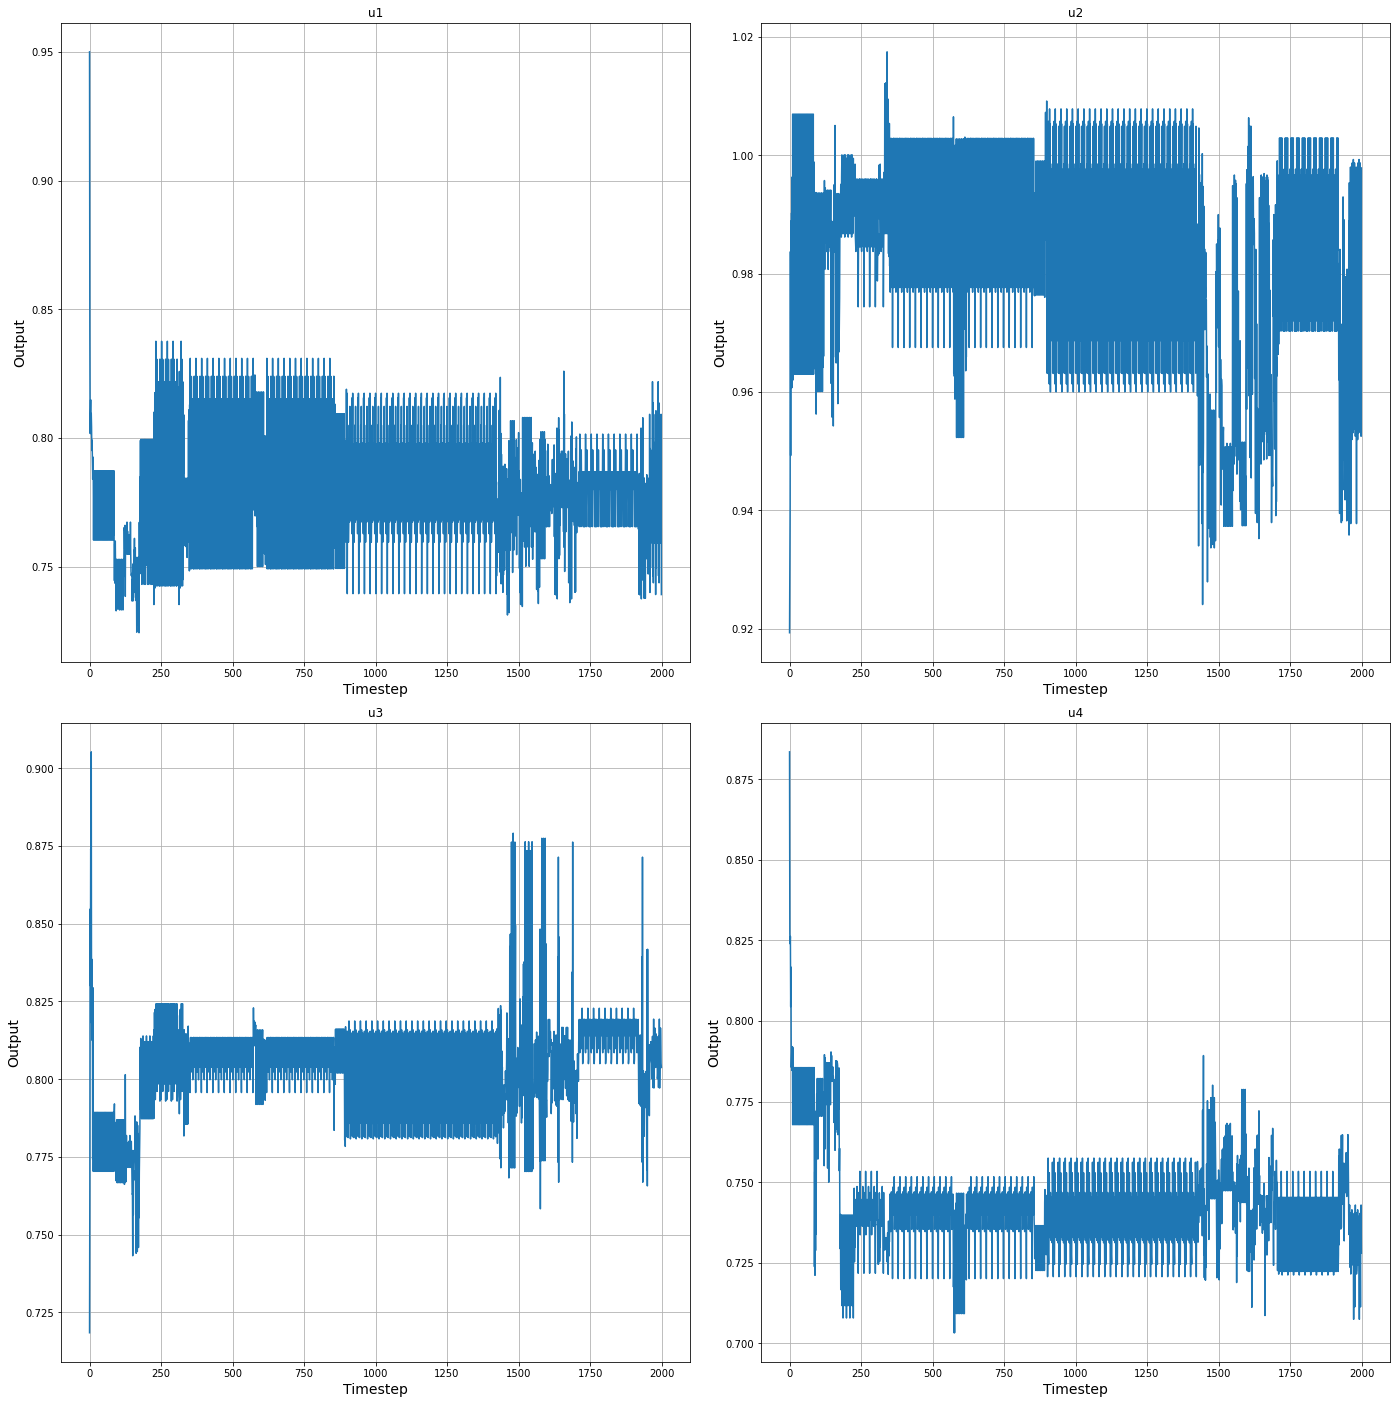

In [48]:
##### longer time
t = np.linspace(0,20,20000)

y_0= np.zeros(19)
y_0[12:16] = (omega_max+omega_min)/2
y_0[0] = 4.
y_0[1] = 0.
y_0[8] = 0.*np.pi/2
y_0[16] = Mx0
y_0[17] = My0
y_0[18] = Mz0

def dydt(t, y):
    dx, dy, dz, vx, vy, vz, phi, theta, psi, p, q, r, omega1, omega2, omega3, omega4, Mx, My, Mz = y
    u = neural_network(y)
    return dynamics(t, y, u)

sol = integrate.solve_ivp(dydt, (0, 20), y_0, t_eval=t)

y_sim = sol.y.T
y_sim_w = np.array([transform_back(yi) for yi in y_sim])

x, y, z, vx, vy, vz, phi, theta, psi, p, q, r, omega1, omega2, omega3, omega4, Mx, My, Mz = y_sim_w.T
u = np.array([neural_network(yi) for yi in y_sim])
# print(u)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
fig.tight_layout(pad=4.0)
labels_output = ["u1", "u2", "u3", "u4"]
# fig.suptitle("Input parameters", fontsize=18)
for i, ax in enumerate(axes.flat):
    ax.plot(u[0: 2000, i], label='Estimated')
    ax.set_xlabel('Timestep', fontdict={"size":14})
    ax.set_ylabel('Output', fontdict={"size":14})
    ax.grid(True)
    ax.set_title(labels_output[i])


In [42]:
animation.animate(t,x,y,z-1,phi,theta,psi,u, waypoints=[np.array([0.,0.,-1.]), np.array([-4.,0.,-1.])])

# Flying a continuous trajectory

In [35]:
from quadcopter_animation import animation
import scipy.interpolate


target1 = np.array([-2.,-2.,-1.])
target2 = np.array([ 2.,-2.,-1.])
target3 = np.array([ 2., 2.,-1.])
target4 = np.array([-2., 2.,-1.])
Mx0, My0, Mz0 = 0, 0, 0

target = target2

t = np.linspace(0, 10, 1000)
t0 = 0

y0_w = np.zeros(19)
y0_w[0:3] = target1
y0_w[12:16] = (dataset["omega_max"] + dataset["omega_min"])/2
y0_w[16] = Mx0
y0_w[17] = My0
y0_w[18] = Mz0


y0 = transform(y0_w)

psi_ref = 0
u_list = []
target_list = []


def dydt(t, y):
    global target, psi_ref, u_list, t0
    # state in world coordinates
    y_w = transform_back(y)
    
    delta_pos = y_w[0:3] - target
    if target is target2:
        psi_ref = 0
        normal = np.array([np.cos(np.pi*1/4), np.sin(np.pi*1/4), 0.])
        if np.linalg.norm(delta_pos) < 0.8:
            target = target3
    elif target is target3:
        psi_ref = np.pi/2
        normal = np.array([np.cos(np.pi*3/4), np.sin(np.pi*3/4), 0.])
        if np.linalg.norm(delta_pos) < 0.8:
            target = target4
    elif target is target4:
        psi_ref = np.pi
        normal = np.array([np.cos(np.pi*5/4), np.sin(np.pi*5/4), 0.])
        if np.linalg.norm(delta_pos) < 0.8:
            target = target1
    elif target is target1:
        psi_ref = -np.pi/2
        normal = np.array([np.cos(np.pi*7/4), np.sin(np.pi*7/4), 0.])
        if np.linalg.norm(delta_pos) < 0.8:
            target = target2
    
           
    
    # describe state relative to target
    y_w[0:3] -= target
    
    nn_input = transform(y_w)
    
    nn_input[8] -= psi_ref
    
    while nn_input[8] > np.pi:
        nn_input[8] -= np.pi*2
    while nn_input[8] < -np.pi:
        nn_input[8] += np.pi*2
    
    
    # control input
    u = neural_network(nn_input) #,Mx,My,Mz)
    u_list.append((t, u))
    target_list.append((t, target))
    
    d_y = dynamics(t, y, u)
    return d_y
    

sol = integrate.solve_ivp(dydt, (t[0], t[-1]), y0, t_eval=t)
y_sim = sol.y.T
y_sim_w = np.array([transform_back(yi) for yi in y_sim])

x, y, z, vx, vy, vz, phi, theta, psi = y_sim_w[:, 0:9].T

t_ = np.array([ti for ti, ui in u_list])
u_ = np.array([ui for ti, ui in u_list])
u_ = scipy.interpolate.interp1d(t_, u_, axis=0, fill_value="extrapolate")
u_ = u_(t)

t_ = np.array([ti for ti, targeti in target_list])
target_ = np.array([targeti for ti, targeti in target_list])
target_ = scipy.interpolate.interp1d(t_, target_, axis=0, fill_value="extrapolate")
target_ = target_(t)

animation.animate(t,x,y,z,phi,theta,psi,u_, target=target_, waypoints=[target1,target2,target3,target4])

In [38]:
import matplotlib.cm as cm
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=0, vmax=6)
cmap = cm.jet

def color_plot(x_axis, y_axis):
    step = 10
    for i in reversed(range(step,len(x_axis),step)):
        ax = plt.gca()
        ax.plot([x_axis[i-step], x_axis[i]], [y_axis[i-step], y_axis[i]])

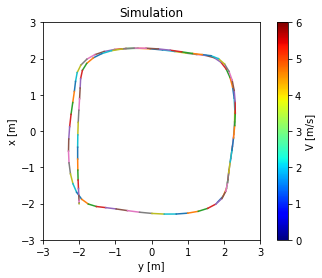

In [39]:
color_plot(y,x)
plt.xlabel('y [m]')
plt.ylabel('x [m]')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect('equal')
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='V [m/s]')
plt.title('Simulation')
plt.show()